<a href="https://colab.research.google.com/github/ArthurCTLin/Workbook/blob/main/ML_Course/HW1/COVID_19_Prediction_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Prediction
* Dataset was provided by Professor Hung-Yi, Lee

In [268]:
!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 132MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 109MB/s]


In [269]:
# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import math
import numpy as np
import pandas as pd
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Reproduction
myseed = 42069
torch.backends.cudnn.deterministic = True 
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
NUM_WORKERS = os.cpu_count()
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Device: cpu
Number of workers: 2


In [270]:
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [271]:
train_dat = pd.read_csv("./covid.train.csv")
train_dat.head()

,id,AL,AK,AZ,AR,CA,CO,CT,FL,GA,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.091433,43.290957,15.214655,1.641667,14.778802,12.417256,16.134238,52.560315,43.321985,20.178428


In [272]:
test_dat = pd.read_csv("./covid.train.csv")
test_dat.head()

,id,AL,AK,AZ,AR,CA,CO,CT,FL,GA,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.091433,43.290957,15.214655,1.641667,14.778802,12.417256,16.134238,52.560315,43.321985,20.178428


In [273]:
with open("./covid.train.csv", "r") as fp:
  data = list(csv.reader(fp))
  data = np.array(data[1:])[:, 1:].astype(float)
  print(data)

[[ 1.         0.         0.        ... 53.9915494 43.6042293 20.7049346]
 [ 1.         0.         0.        ... 54.185521  42.6657659 21.2929114]
 [ 1.         0.         0.        ... 53.6370693 42.972417  21.1666563]
 ...
 [ 0.         0.         0.        ... 67.731162  38.740651  12.6134414]
 [ 0.         0.         0.        ... 67.7950996 38.595125  12.4772268]
 [ 0.         0.         0.        ... 68.2840782 38.4538196 11.8117187]]


In [274]:
data.shape

(2700, 94)

In [275]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

train_set = pd.read_csv('./covid.train.csv')
x = train_set[train_set.columns[1:94]]
y = train_set[train_set.columns[94]]

from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

# The normalization method
norm = MinMaxScaler() # Min-max scaling (Can be tuned)
train_set_norm = pd.DataFrame(norm.fit_transform(x), columns=x.keys()) 

bestfeats = SelectKBest(score_func=f_regression)
fit = bestfeats.fit(train_set_norm, y)
dfcolumns = pd.DataFrame(train_set_norm.columns)
dfscores = pd.DataFrame(fit.scores_)

featureScores = pd.concat([dfcolumns,dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
featureScores.sort_values('Score', ascending = False, inplace = True) 
feats_id = list(featureScores.head(14).index)
print(feats_id)
featureScores.head(30)

[75, 57, 42, 60, 78, 43, 61, 79, 40, 58, 76, 41, 59, 77]


,Specs,Score
75,tested_positive.1,148069.658278
57,tested_positive,69603.872591
42,hh_cmnty_cli,9235.492094
60,hh_cmnty_cli.1,9209.019558
78,hh_cmnty_cli.2,9097.375172
43,nohh_cmnty_cli,8395.421300
61,nohh_cmnty_cli.1,8343.255927
79,nohh_cmnty_cli.2,8208.176435
40,cli,6388.906849
58,cli.1,6374.548000


In [276]:
class COVID19Dataset(Dataset):
  def __init__(self, path, mode="train", target_only=False):
    self.mode = mode

    with open(path, 'r') as fp:
      data = list(csv.reader(fp))
      data = np.array(data[1:])[:, 1:].astype(float)
    
    if not target_only:
      feats = list(range(93))
    else:
      feats = feats_id
    
    if mode == "test":
      data = data[:, feats]
      self.data = torch.FloatTensor(data)
    else:
      target = data[:, -1]
      data = data[:, feats]

      if mode == "train":
        indices = [i for i in range(len(data)) if i%15!=0]
      elif mode == "dev":
        indices = [i for i in range(len(data)) if i%15==0]
      
      self.data = torch.FloatTensor(data[indices])
      self.target = torch.FloatTensor(target[indices])
    
    # Feature normalization
    self.data[:, 40:] = (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) / self.data[:, 40:].std(dim=0, keepdim=True)
    self.dim = self.data.shape[1]
    
    print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

  def __getitem__(self, index):
    if self.mode in ["train", "dev"]:
      return self.data[index], self.target[index]
    else:
      return self.data[index]
  
  def __len__(self):
    return len(self.data)

In [277]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
  dataset = COVID19Dataset(path, mode=mode, target_only=target_only)
  dataloader = DataLoader(dataset, batch_size, shuffle=(mode=="train"), drop_last=False, num_workers=n_jobs, pin_memory=True)

  return dataloader

In [278]:
from torch.nn.modules.activation import LeakyReLU, ReLU
class NeuralNet(nn.Module):
  def __init__(self, input_dim):
    super(NeuralNet, self).__init__()

    '''
    self.net = nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Linear(64, 16),
        nn.BatchNorm1d(16),
        nn.ReLU(),
        nn.Linear(16, 1)
    )
    '''
    self.net = nn.Sequential(
        nn.Linear(input_dim, 32),
        nn.BatchNorm1d(32),
        nn.Dropout(p=0.2),
        #nn.SELU(),
        nn.LeakyReLU(0.3),
        nn.Linear(32, 1)
    )
    
    self.criterion = nn.MSELoss(reduction="mean")

  def forward(self, x):
    return self.net(x).squeeze(1)
  
  def cal_loss(self, pred, target):
    regularization_loss = 0
    eps = 1e-6
    for param in model.parameters():
      #regularization_loss += torch.sum(abs(param)) # L1 regularization
      regularization_loss += torch.sum(param**2) # L2 regularization
    return torch.sqrt(self.criterion(pred, target) + eps)
    #return torch.sqrt(self.criterion(pred, target) + eps) + 0.0005*regularization_loss
    ##return self.criterion(pred, target) + 0.0008*regularization_loss

In [279]:
def train(train_set, dev_set, model, config, device):
  n_epochs = config["n_epochs"]

  # Setup optimizer
  optimizer = getattr(torch.optim, config["optimizer"])(model.parameters(), **config["optim_hparas"])

  min_mse = math.inf
  loss_record = {"train": [], "dev": []}
  early_stop_count = 0
  epoch = 0
  while epoch < n_epochs:
    model.train()
    for x, y in train_set:
      optimizer.zero_grad()
      x, y = x.to(device), y.to(device)
      pred = model(x)
      mse_loss = model.cal_loss(pred, y)
      mse_loss.backward()
      optimizer.step()
      loss_record["train"].append(mse_loss.detach().cpu().item())
    
    dev_mse = dev(dev_set, model, device)
    if dev_mse < min_mse:
      min_mse = dev_mse
      print("Saving mode (epoch = {:4d}, loss = {:.4f})".format(epoch+1, min_mse))
      torch.save(model.state_dict(), config["save_path"])
      early_stop_count = 0
    else:
      early_stop_count += 1
    
    epoch += 1
    loss_record["dev"].append(dev_mse)
    if early_stop_count > config["early_stop"]:
      break

  print("Finished training after {} epochs".format(epoch))
  return min_mse, loss_record


In [280]:
def dev(dev_set, model, device):
  model.eval()
  total_loss = 0
  for x, y in dev_set:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
      pred = model(x)
      mse_loss = model.cal_loss(pred, y)
    total_loss += mse_loss.detach().cpu().item()
  total_loss = total_loss / len(dev_set.dataset)

  return total_loss

In [281]:
def test(test_set, model, device):
  model.eval()
  preds = []
  for x in test_set:
    x = x.to(device)
    with torch.no_grad():
      pred = model(x)
      preds.append(pred.detach().cpu())
  preds = torch.cat(preds, dim=0).numpy()
  return preds

In [282]:
os.makedirs("models", exist_ok=True)
target_only = True

config = {
    "n_epochs" : 10000,
    "batch_size" : 256,
    "optimizer" : "Adam",
    "optim_hparas":{
        "lr" : 0.0005,
        #"momentum": 0.9,
        "weight_decay" : 0.003
    },
    "early_stop" : 500,
    "save_path" : "models/model.pth"
}

In [283]:
train_path = 'covid.train.csv'  # path to training data
test_path = 'covid.test.csv'   # path to testing data

train_set = prep_dataloader(train_path, "train", config["batch_size"], target_only=target_only)
dev_set = prep_dataloader(train_path, "dev", config["batch_size"], target_only=target_only)
test_set = prep_dataloader(test_path, "test", config["batch_size"], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2520 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (180 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 14)


In [284]:
model = NeuralNet(train_set.dataset.dim).to(device)

In [285]:
model_loss, model_loss_record = train(train_set, dev_set, model, config, device)

Saving mode (epoch =    1, loss = 0.0964)
Saving mode (epoch =    3, loss = 0.0952)
Saving mode (epoch =    4, loss = 0.0941)
Saving mode (epoch =    8, loss = 0.0940)
Saving mode (epoch =    9, loss = 0.0936)
Saving mode (epoch =   11, loss = 0.0934)
Saving mode (epoch =   13, loss = 0.0933)
Saving mode (epoch =   14, loss = 0.0927)
Saving mode (epoch =   15, loss = 0.0925)
Saving mode (epoch =   16, loss = 0.0916)
Saving mode (epoch =   17, loss = 0.0886)
Saving mode (epoch =   18, loss = 0.0865)
Saving mode (epoch =   25, loss = 0.0859)
Saving mode (epoch =   26, loss = 0.0853)
Saving mode (epoch =   27, loss = 0.0844)
Saving mode (epoch =   28, loss = 0.0826)
Saving mode (epoch =   29, loss = 0.0815)
Saving mode (epoch =   30, loss = 0.0808)
Saving mode (epoch =   31, loss = 0.0791)
Saving mode (epoch =   32, loss = 0.0785)
Saving mode (epoch =   35, loss = 0.0782)
Saving mode (epoch =   36, loss = 0.0767)
Saving mode (epoch =   37, loss = 0.0749)
Saving mode (epoch =   38, loss = 

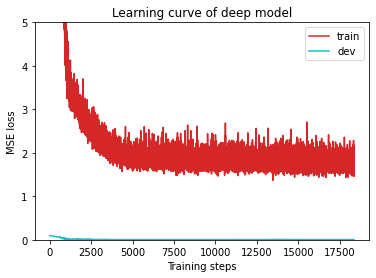

In [286]:
plot_learning_curve(model_loss_record, title='deep model')

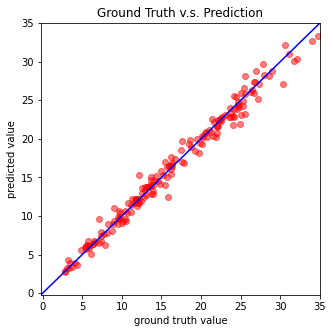

In [287]:
del model
model = NeuralNet(train_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dev_set, model, device)  # Show prediction on the validation set

In [288]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(test_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv
